In [0]:
!pip install git+https://github.com/pabloppp/pytorch-tools -U

In [0]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchtools.vq import VectorQuantize
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFile

In [0]:
mnist = torchvision.datasets.MNIST('data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(mnist, batch_size=16, shuffle=True)

In [0]:
def show_images(image_list):
    images = torch.cat(image_list, dim=-1)
    if images.size(0) == 1:
        images = images.squeeze(0)
        plt.imshow(images, cmap="Greys_r")
    else:
        images = images.permute(1,2,0)
        plt.imshow(images)
    plt.axis('off')
    plt.rcParams["figure.figsize"] = (3*len(image_list), 3)
    plt.show()

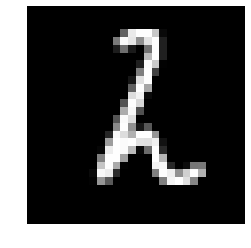

In [4]:
images, _ = next(iter(dataloader))
show_images([images[0]])

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)
            
class ResBlock(nn.Module):
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class VqVAE(nn.Module):
    def __init__(self, k=256, label_count=10):
        super(VqVAE, self).__init__()
        
        latent_size = 32
        hidden_size = 64
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=4,  stride=2, padding=1),
            ResBlock(hidden_size),
            ResBlock(hidden_size),
            nn.Conv2d(hidden_size, latent_size, kernel_size=3, padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_size+label_count, hidden_size, kernel_size=3, padding=1),
            ResBlock(hidden_size),
            ResBlock(hidden_size),
            nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        self.label_count = label_count
        self.vquantizer = VectorQuantize(latent_size, k, ema_loss=True)
        
        self.apply(weights_init)
        
    def encode(self, x):
        encoded = self.encoder(x)
              
        q, (_, commit_loss), indices = self.vquantizer(encoded.permute(0, 2, 3, 1))        
        q = q.permute(0, 3, 1, 2)
  
        return q, commit_loss, indices
     
    def decode(self, x, labels=None):
        if labels is not None:
            condition = nn.functional.one_hot(labels.view(-1, 1, 1), num_classes=self.label_count).float()
            condition = condition.expand(x.size(0), x.size(2), x.size(3), -1).permute(0, 3, 1, 2)
        else:
            condition = x.new_zeros((x.size(0), self.label_count, x.size(2), x.size(3)))
        x = torch.cat((x, condition), dim=1)
        return self.decoder(x)   
    
    def forward(self, x, label=None):
        q, commit_loss, _ = self.encode(x)
        decoded = self.decode(q, label)

        return decoded, commit_loss

In [6]:
vqVAE = VqVAE(2, label_count=10)
vqVAE.cuda()

VqVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ResBlock(
      (block): Sequential(
        (0): ReLU()
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): ResBlock(
      (block): Sequential(
        (0): ReLU()
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): Conv2d(64, 64, 

torch.Size([16, 1, 28, 28]) torch.Size([16, 1, 28, 28]) 0.07180970907211304


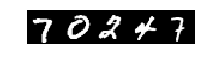

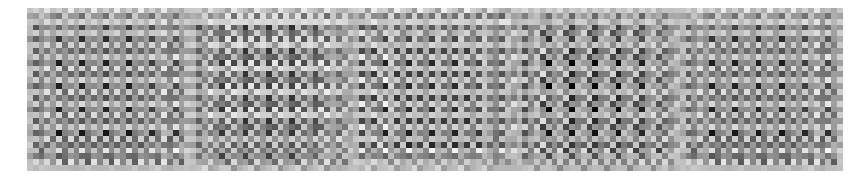

In [7]:
with torch.no_grad():
    images, labels = next(iter(dataloader))
    images, labels = images.cuda(), labels.cuda()

    vqVAE.eval()
    decoded, commit_loss = vqVAE.forward(images, labels)
    vqVAE.train()   

    print(images.shape, decoded.shape, commit_loss.item())

    show_images([b for b in images[:5].cpu()])
    show_images([b for b in decoded[:5].cpu()])

5622272
EPOCH 1 (1500/3750) - loss 0.06223625120023887 - recon 0.034600028389443954 - commit 0.11054489126304785


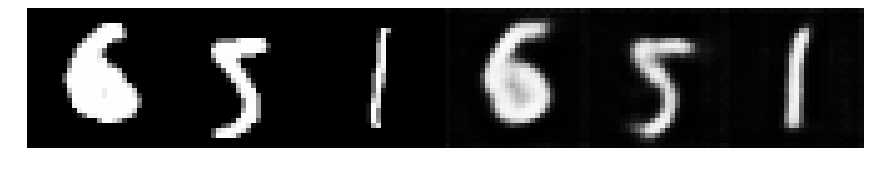

5622272
EPOCH 1 (3000/3750) - loss 0.055681391843905054 - recon 0.027545392117773494 - commit 0.11254399903863668


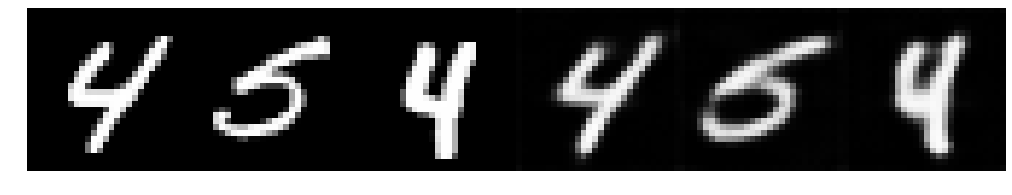

5622272
EPOCH 1 (3750/3750) - loss 0.05383286745150884 - recon 0.025882097892214854 - commit 0.11180307828386625


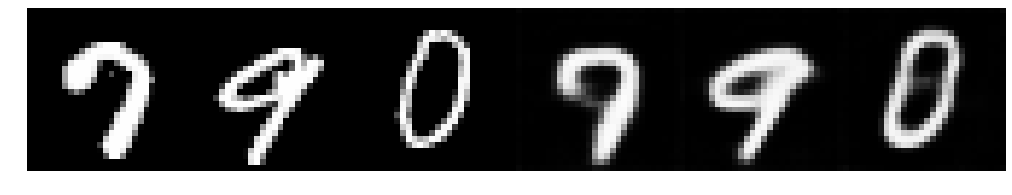

5622272
EPOCH 2 (1500/3750) - loss 0.04379983513057232 - recon 0.01833653362219532 - commit 0.10185320603350799


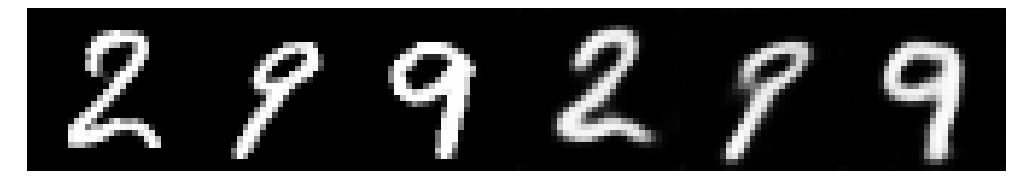

5622272
EPOCH 2 (3000/3750) - loss 0.04260958505173524 - recon 0.01802730634777496 - commit 0.0983291147351265


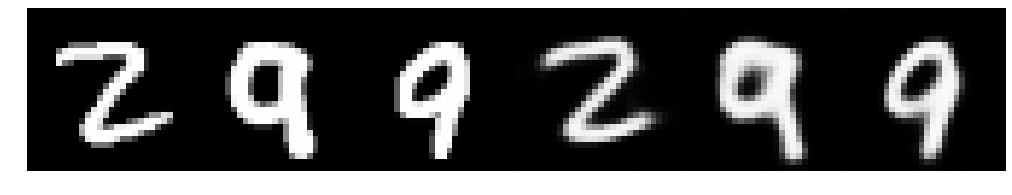

5622272
EPOCH 2 (3750/3750) - loss 0.04202741297384103 - recon 0.017884005049367747 - commit 0.09657363162636756


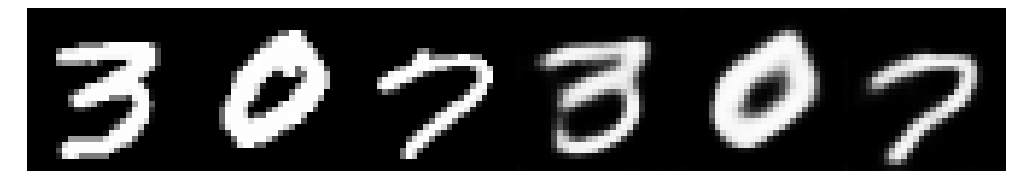

5622272
EPOCH 3 (1500/3750) - loss 0.03835120389362176 - recon 0.016903813536589346 - commit 0.08578956147531669


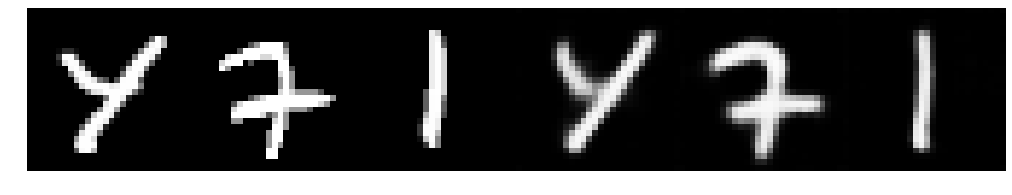

5622272
EPOCH 3 (3000/3750) - loss 0.037565653048455716 - recon 0.01671424154440562 - commit 0.08340564598018925


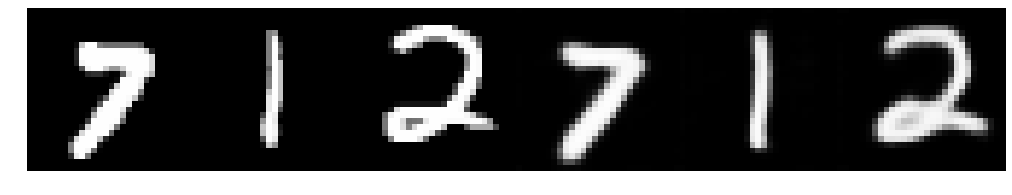

5622272
EPOCH 3 (3750/3750) - loss 0.03724175363530715 - recon 0.016624589619537194 - commit 0.08246865606804689


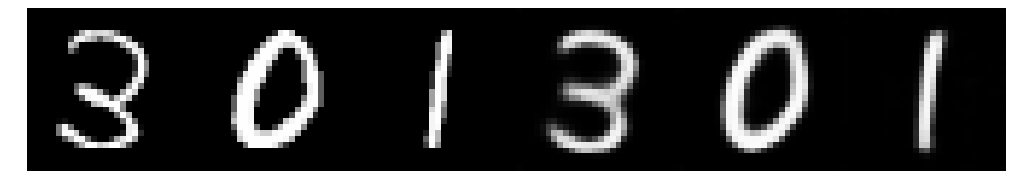

5622272
EPOCH 4 (1500/3750) - loss 0.03536517106493314 - recon 0.016055670587345958 - commit 0.07723800182839234


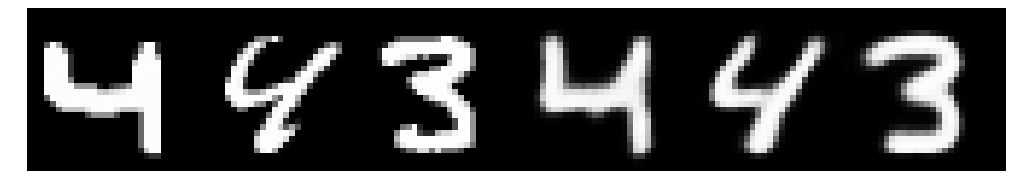

5622272
EPOCH 4 (3000/3750) - loss 0.03488645100593567 - recon 0.015955882845136028 - commit 0.07572227260967096


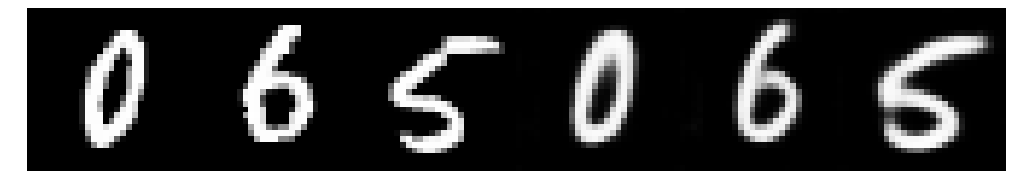

5622272
EPOCH 4 (3750/3750) - loss 0.03464636799643437 - recon 0.015888898979624113 - commit 0.07502987601359686


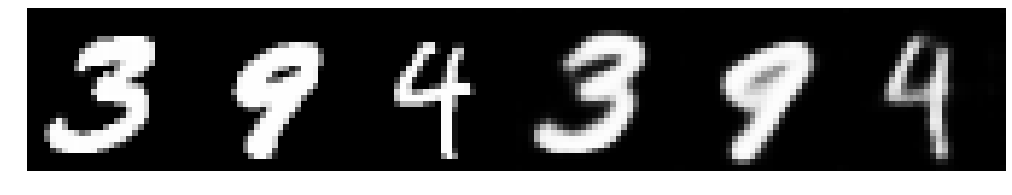

5622272
EPOCH 5 (1500/3750) - loss 0.03341989618291458 - recon 0.015495989028985302 - commit 0.07169562838971615


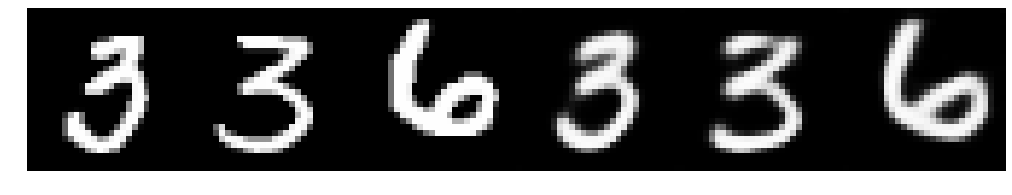

5622272
EPOCH 5 (3000/3750) - loss 0.03309527168298761 - recon 0.015400560537663598 - commit 0.0707788444943726


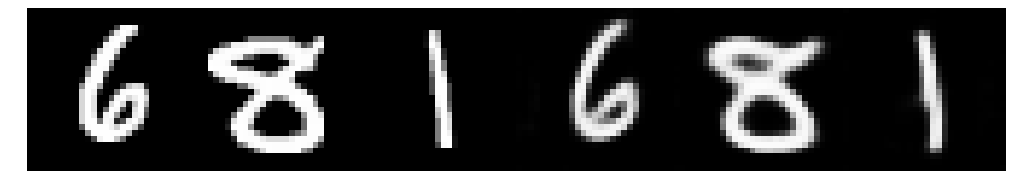

5622272
EPOCH 5 (3750/3750) - loss 0.032964840018252534 - recon 0.015358839365591605 - commit 0.07042400255699953


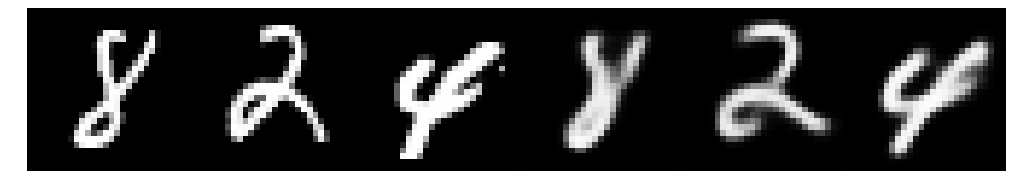

In [8]:
optimizer = optim.Adam(vqVAE.parameters(), lr=0.0002)
epochs = 5
print_every = 1500

vqVAE.cuda()
for e in range(1, epochs+1):
    total_loss = 0
    total_loss_recon = 0
    total_loss_commit = 0
    vqVAE.train()
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.cuda(), labels.cuda()
        
        decoded, commit_loss = vqVAE.forward(images, labels)
        recon_loss = (decoded - images).pow(2).mean()
        loss = recon_loss + commit_loss * 0.25
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_loss_recon += recon_loss.item()
        total_loss_commit += commit_loss.item()
        
        if (batch+1) % print_every == 0 or (batch+1) == len(dataloader):
            print(torch.cuda.memory_allocated())
            print(f"EPOCH {e} ({batch+1}/{len(dataloader)}) - loss {total_loss/(batch+1)} - recon {total_loss_recon/(batch+1)} - commit {total_loss_commit/(batch+1)}")
            show_images([b for b in images[:3].cpu()] + [b for b in decoded[:3].cpu().detach()])



/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:251: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


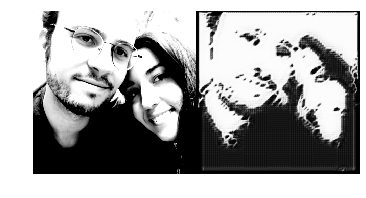

In [14]:
vqVAE.eval()

bw = Image.open("pp.jpeg").convert('L')
bw = torchvision.transforms.functional.scale(bw, 320)
bw = torchvision.transforms.functional.adjust_contrast(bw, 3)
bw = torchvision.transforms.functional.to_tensor(bw).unsqueeze(0)

with torch.no_grad():
    q, _, _= vqVAE.encode(bw.cuda())    
    gen = vqVAE.decode(q, torch.tensor([6]).cuda())

    show_images([bw.cpu()[0], gen.cpu()[0]])

In [0]:
images, labels = next(iter(dataloader))
images, labels = images[0:1].cuda(), labels[0:1].cuda()

torch.Size([1, 7, 7])
[[[1 1 1 0 1 1 1]
  [1 1 0 1 0 1 1]
  [1 1 1 1 0 1 1]
  [1 1 1 0 1 1 1]
  [1 1 1 1 0 1 1]
  [1 1 0 1 0 1 1]
  [1 1 1 0 1 1 1]]]


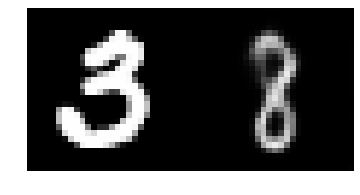

In [74]:
vqVAE.eval()
with torch.no_grad():
    _, _, idx = vqVAE.encode(images)    

    print(idx.shape)
    idx = 1 - torch.tensor([[
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]
    ]]).cuda()

    q = vqVAE.vquantizer.codebook(idx).permute(0, 3, 1, 2)
    # gen = [vqVAE.decode(q, torch.tensor([i]).cuda())[0].cpu() for i in range(9)]
    gen = vqVAE.decode(q, torch.tensor([8]).cuda()) #labels) 

    print(idx.cpu().numpy())

    # show_images([images[0].cpu()] + gen)
    show_images([images[0].cpu(), gen[0].cpu()])